Preliminary notebook exploring processing strategies for specific stimulus epochs of V1DD-2P dataset.
Specficially, we will examine the population responses to  `drifting_gratings_full`, `spontaneous` and `natural_movies`,

**Authors:**
Arun Cherkkil, Libby Zhang

**Initial steps**
- Just focus on volumes 2 and 3 (the "good" volumes)
- Scaling the dF/F traces using a min-max scaler
  - Maybe consider some robust min-max scaling, e.g. between the 1st and 99th percentile
- Bin at the 2s timebins of `drifting_gratings_full`
    - Stringer et al. 2019 used a 1.2-1.3s binning for their analyses, so this is on a similar order.

**Sumary**
- Binned the data for the first epoch of `drifting_gratings_full`
- This data should be in a good preliminary form for Arun to begin working on

*Additional notes*
- Here, just looking at volume 2, one of the good volumes
- Verified robust min-max scaling strategy for dF/F normalization, standard scaling for behavioral variables

**Completed**
- [Arun] Begin identifying single vs population level correlation to identify soloists vs. choristers in this epoch
    - In particular apply novel data-driven strategies to separate cells based on their population coupling strength 
    - To study how the population coupling strength is agnostic to behavior trial 
    - Dimensionality reduction analysis: Use PCA, eignen spectrum analysis to study cell state space contribution. 
    - To validate results using linear regression analysis and other cross validation tools
    
        
- [Libby]: Streamline the processing pipeline so that we can easily apply to other epochs
  - In particular, the binning is a bit clunky and relies on the `drifitng_gratings_full` having defined stimulus times
  
**Next Steps**

- [Arun]: Apply validation metrics to verify the cell classification 
    - Bootstrapping - Shuffled calcium datasets from n=3 separate trails and calculate population coupling strength distributions
    - Model analysis - To use unsupervised or supervised models (SVM/RNN) to represent the two population clusters. 
    - Function-Structure relationship - Use co-registered information of cells to understand the underlying network structures and efferent/ afferent connection, synapse strength and other anatomical features of soloists vs choristers. 
- [Libby]: Test out different ways to regress out behavior; definitely seems like a big factor
  - Standard scale the behavior variables (by stimulus epoch)
  - Ridge regresssion!!! Extreme collinearity between pupil and running.

- [Instructor feedback]  
  Vergil: Try out a behavioral gain (multiplicative) modulation. Let A and B be the two behavioral traces. Construct a 3rd variable, $x_C = x_A x x_B$. Now, fit a linear (ridge) regression to the 3 variables. Residuals consist of (pay close attention!!!!:  $$y_\textrm{resid} = [y_A - \hat{y}_A, y_B - \hat{y}_B, y_C/\hat{y}_C]$$
    - Gain modulation of behavioral variables is definitely observed in the visual cortex.
  - Vergil: Using a more complicated model,
  - Minor: Time lagged behavioral variables (although binning should help!)


In [1]:
%load_ext autoreload
%autoreload 2

# general imports 
import os
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm

import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler
import pandas as pd 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

# Add package to path
import sys
sys.path.insert(0, '/root/capsule/code/src')
# Add package to path
import sys
sys.path.insert(0, '/root/capsule/code/src')
from funcky.utils import (
    load_nwb_session,
    get_aligned_session_data,
    get_epoch_data,
    bin_and_avg_data,
)

In [2]:
# Specify data directory location
DATA_DIR = "/data/"  # Code Ocean

# Load metadata csv, which contains session, subject, column, and volume info
metadata = pd.read_csv('/root/capsule/metadata/V1DD_metadata.csv')

## Loading Processed Data 

In [3]:
selected_session = metadata[
    (metadata['golden_mouse']==True)    # mouse with structural info
    & (metadata['column']==1)           # center imaging column
    & (metadata['volume']==3)           # not top or bottom volume
]

assert len(selected_session) == 1, \
    f"Expected exactly 1 session, got {len(selected_session)}"

nwb = load_nwb_session(selected_session.name.item(), DATA_DIR)
session_data = get_aligned_session_data(nwb)

# =============================================================================
# Get stimulus epochs of interest
selected_stimuli = [
    'drifting_gratings_full',
    'spontaneous',
    'natural_movie',
]

stim_epochs_df = nwb.epochs.to_dataframe()
stim_epochs_df = stim_epochs_df[
    stim_epochs_df['stim_name'].isin(selected_stimuli)
]

# =============================================================================
# Filter data
list_of_epoch_data = [
    get_epoch_data(session_data, start_time, stop_time)
    for start_time, stop_time in zip(stim_epochs_df.start_time.values, stim_epochs_df.stop_time.values)
]

# Apply scaling and other processing
# - dff_traces : no additional processing needed
pass

# - behavior_traces : apply standard scaling to each feature independently
# Fit scaler to all data that we are analyzing
list_of_bhv_traces = [dd['behavior_traces'] for dd in list_of_epoch_data]
all_bhv_traces = np.concatenate(list_of_bhv_traces, axis=0) # shape (n_total_time, n_behave)
all_bhv_traces = StandardScaler().fit_transform(all_bhv_traces)




/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.9.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


  0%|          | 0/6 [00:00<?, ?it/s]

/root/capsule/code/src/funcky/utils.py:166: UserWarning: pupil: 516 NaNs detected; fillin in via interpolation.
  warnings.warn(


In [5]:
# To create a widget 
from nwbwidgets import nwb2widget
nwb2widget(nwb)

In [173]:
# TO plot the normalized behavior variables 
plt.figure(figsize=(40, 20))
plt.plot(all_bhv_traces)
plt.close()

In [7]:
# To create and check the length of the list containing the epoch data structure
len(list_of_epoch_data)

5

In [8]:
# To correct the index for the stimulus epochs
stim_epochs_df = stim_epochs_df.reset_index(drop=True)
stim_epochs_df

stim_name   start_time    stop_time    duration
0  drifting_gratings_full    54.634430   341.856873  287.222443
1             spontaneous   876.318604  1176.552002  300.233398
2           natural_movie  1343.707764  1794.066162  450.358398
3  drifting_gratings_full  2704.841309  2992.063721  287.222412
4           natural_movie  2997.084473  3537.517822  540.433350

In [9]:
# Archived scripts - AC 
# def filter_session_data(session_data, start_times, stop_times):
#     """Return session data with timestamps and traces filtered by start and stop times.

#     Parameters
#     ----------
#     session_data : dict
#     start_times : float or Sequence[float]
#     stop_times : float or Sequence[float]
#         Start and stop times to filter data by. Must be both scalar or same length sequences.
#     """

#     if isinstance(start_times, float):
#         start_times == [start_times]
#         stop_times == [stop_times]
    
#     if len(start_times) != len(stop_times):
#         raise ValueError(
#             "Expected `start_times` and `stop_times` to be scalars or sequences of the same length, " \
#             + f"but got {len(start_times)=} and {len(stop_times)=}."
#         )
    
#     timestamps = session_data['timestamps']
#     mask = np.zeros_like(timestamps, dtype=bool)
#     for start_time, stop_time in zip(start_times, stop_times):
#         mask |= (timestamps >= start_time) & (timestamps <= stop_time)

#     filtered_session_data = {}
#     for k, v in session_data.items():
#         # If time series field, apply mask
#         if (k=='timestamps') or ('_traces' in k):
#             filtered_session_data[k] = v[...,mask]
        
#         # Else, copy as is
#         else:
#             filtered_session_data[k] = v

#     return filtered_session_data

# selected_session_data =  filter_session_data(session_data, stim_epochs_df.start_time.values, stim_epochs_df.stop_time.values)

# for k, v in selected_session_data.items():
#     print(f"{k}: {v.shape}")

**Visualizing population average**

In [174]:
session_data_ = list_of_epoch_data

row_labels = ['dF/F', 'running', 'pupil']

# =========================================================================
width_ratios = np.array([len(dd['timestamps']) for dd in session_data_])

fig, axs = plt.subplots(
    ncols=len(width_ratios), width_ratios=width_ratios, sharey="row",
    nrows=len(row_labels), height_ratios=[1,0.2,0.2], sharex="col",
    figsize=(12,6)
)
fig.subplots_adjust(wspace=0.2, hspace=0.1,)

# Loop through each column, i.e. each stimulus epoch
for i_col, dd in zip(range(axs.shape[-1]), session_data_):

    _ts = dd['timestamps']
    _dff = dd['dff_traces']
    _bhv = dd['behavior_traces']
    _dff_avg = _dff.mean(axis=-1)
    _dff_std = _dff.std(axis=-1)

    # ----------------------------------
    # Row 1: Plot avg population trace
    # ----------------------------------
    i_row = 0
    ax = axs[i_row,i_col]
    ax.plot(_ts, _dff_avg, lw=1, alpha=0.5, c='C0')
    ax.fill_between(
        _ts, _dff_avg-_dff_std, _dff_avg+_dff_std,
        color='C0', ec='none', alpha=0.1, zorder=1
    )  # 1 std

    # ----------------------------------
    # Rows 2+: Plot behavior traces
    # ----------------------------------
    for i_row in range(1, len(axs)):
        ax = axs[i_row,i_col]
        name = row_labels[i_row]

        ax.plot(_ts, _bhv[:,i_row-1], color=f'C{i_row}')    
    
# Make pretty!
for (i_row, i_col), ax in np.ndenumerate(axs):
    ax.margins(x=0.0)

    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel('time [s]')
    
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(row_labels[i_row])

    if ax.get_subplotspec().is_first_row():
        ax.set_title(stim_epochs_df.iloc[i_col]['stim_name'])

fig.suptitle(
    f'subject={selected_session.subject_id.item()}, '
    + f'col={selected_session.column.item()}, '
    + f'vol={selected_session.volume.item()}'
    + ', population avg response, window_size=0, window_overlap=0',
)

sns.despine()

plt.savefig('/results/average_dff_across_stimulus.png',format='png')
plt.close()

### dF/F and behavioral traces, with normalization

**Min-max scaling of dF/F**
We do a robust min-max scaling of the calcium imaging traces, between the 0.5-th to 99.5th percentiles.

In [23]:
# for pct in [0, 0.5, 1, 5]:
#     print(f"{pct} pct: {np.percentile(selected_session_data['dff_traces'], pct):.3f}")

# print()
# for pct in [95, 99, 99.5, 99.9, 100]:
#     print(f"{pct} pct: {np.percentile(selected_session_data['dff_traces'], pct):.3f}")

In [24]:
# This function was written to minmax normalize the data 
# def robust_min_max_scaler(arr, min_pct=0, max_pct=100, axis=1):
#     min_val = np.percentile(arr, min_pct, axis=axis, keepdims = True)
#     max_val = np.percentile(arr, max_pct, axis=axis, keepdims = True)
#     print(min_val.shape)
#     return (arr-min_val) / (max_val-min_val)



# from copy import deepcopy
# normd_sel_session_data = deepcopy(selected_session_data)
# normd_sel_session_data['dff_traces'] = robust_min_max_scaler(
#     normd_sel_session_data['dff_traces'], 0.5, 99.9
# )

# # standard scale the behavioral data indepdently
# selected_session_data['behavior_traces'] = np.array([
#     StandardScaler().fit_transform(trace[:,None]).squeeze() for trace in selected_session_data['behavior_traces']
# ])

# for k, v in selected_session_data.items():
#     print(f"{k}: {v.shape}")

## Plot the normalized dff traces and the population average activity as subplot - AC

In [25]:
# Code to extract metadata on stimulus epochs from nwb file-format
stimulus_table = nwb.intervals['stimulus_table'].to_dataframe()
stim_epochs_df

stim_name   start_time    stop_time    duration
0  drifting_gratings_full    54.634430   341.856873  287.222443
1             spontaneous   876.318604  1176.552002  300.233398
2           natural_movie  1343.707764  1794.066162  450.358398
3  drifting_gratings_full  2704.841309  2992.063721  287.222412
4           natural_movie  2997.084473  3537.517822  540.433350

In [30]:
# Code to extract metadata- stimulus time stamp data

nwb_stimulus_presentation = nwb.intervals['stimulus_table'].to_dataframe()
stim_names = stim_epochs_df['stim_name'].unique()
nwb_stimulus_presentation = nwb_stimulus_presentation[nwb_stimulus_presentation['stim_name'].isin (stim_names)]
nwb_stimulus_presentation['stim_name'].value_counts()
nwb_stimulus_presentation.head()

stim_name  start_time  stop_time  temporal_frequency  \
id                                                                      
0   drifting_gratings_full   54.634430  56.619442                 1.0   
1   drifting_gratings_full   57.636951  59.622009                 1.0   
2   drifting_gratings_full   60.639420  62.624439                 1.0   
3   drifting_gratings_full   63.641949  65.626930                 1.0   
4   drifting_gratings_full   66.644447  68.629433                 1.0   

    spatial_frequency  direction  frame  image_order  image_index  \
id                                                                  
0                0.04       30.0    NaN          NaN          NaN   
1                0.08      300.0    NaN          NaN          NaN   
2                0.04      300.0    NaN          NaN          NaN   
3                0.08      300.0    NaN          NaN          NaN   
4                0.04      330.0    NaN          NaN          NaN   

    stimulus_condition_id  
id                         
0                       1  
1                      22  
2                      10  
3                      22  
4                      11

In [41]:
# A code to plot the population activity modified based on new data structure AC 

def plot_population_activity (stimulus_order,output_filename,add_pointer = 0 ):
    
   
    dff_filtered = list_of_epoch_data[stimulus_order]['dff_traces'].T
    vmin = np.percentile(dff_filtered, 1)
    vmax = np.percentile(dff_filtered, 99.9)
    print(dff_filtered.shape)
    population_level_activity = np.mean(dff_filtered, axis = 0)
    print(population_level_activity.shape)
     
    epoch_start = stim_epochs_df['start_time'][stimulus_order]
    epoch_stop = stim_epochs_df['stop_time'][stimulus_order]
    
    fig, axs = plt.subplots(nrows=2, height_ratios=[1,0.2],figsize=(12,6), sharex=True)

    axs[0].imshow(dff_filtered,vmin = vmin , vmax = vmax, extent=[list_of_epoch_data[stimulus_order]['timestamps'][0], list_of_epoch_data[stimulus_order]['timestamps'][-1], 0, dff_filtered.shape[0]], aspect = "auto")
    axs[1].plot(list_of_epoch_data[stimulus_order]['timestamps'], population_level_activity)
    axs[0].set_xlim(epoch_start,epoch_stop)
    axs[0].set_title(f" DFF traces for the epoch {stim_epochs_df.loc[stimulus_order,'stim_name']}")
    axs[1].set_title(f" Average population level activity for the epoch {stim_epochs_df.loc[stimulus_order,'stim_name']}")
    axs[1].set_xlim(epoch_start,epoch_stop)   
    # Find all stimulus onsets within the epoch
    if add_pointer == 1: 
        y_top = axs[1].get_ylim()[1]
        arrow_length = 0.05 * (axs[1].get_ylim()[1] - axs[1].get_ylim()[0]) 
        mask = (nwb_stimulus_presentation['start_time'] >= epoch_start) & \
               (nwb_stimulus_presentation['start_time'] <= epoch_stop)
        for stim_time in nwb_stimulus_presentation['start_time'][mask]:
            axs[1].arrow(
                stim_time, y_top, 0, -arrow_length,  # arrow points downward from top
                head_width=0.5, head_length=arrow_length,
                fc='red', ec='red', length_includes_head=True
            )
    
    plt.savefig(f'/results/{output_filename}.png', format ='png')
   
    return dff_filtered

In [179]:
# Function calls to plot each heatmap and the corresponding average activity sideways 
dff_drifting_gratings_0 = plot_population_activity(0,'dff_drifting_gratings_0', add_pointer = 1)
plt.close()

(2708, 1742)
(1742,)


In [180]:
dff_drifting_gratings_1 = plot_population_activity(3,'dff_drifting_gratings_1', add_pointer = 1)
plt.close()

(2708, 1735)
(1735,)


In [181]:
dff_natural_movies_0 = plot_population_activity(2,'dff_natural_movies_0', add_pointer = 0)
plt.close()

(2708, 2725)
(2725,)


In [182]:
dff_natural_movies_1 = plot_population_activity(4, 'dff_natural_movies_1')
plt.close()

(2708, 3267)
(3267,)


In [183]:
dff_spontaneous = plot_population_activity(1,'dff_spontaneous' )
plt.close()

(2708, 1820)
(1820,)


In [49]:
# Creating a dictionary of dff traces for each conditions 
dff_dict = {'dff_gratings' : dff_drifting_gratings_0, 'dff_gratings_2' : dff_drifting_gratings_1, 'dff_natural_movies_0' : dff_natural_movies_0, 'dff_natural_movies_1' : dff_natural_movies_1, 'dff_spontaneous' : dff_spontaneous}

In [51]:
# # Code to calculate population couling metrics across different stimulus - AC
# def population_coupling(stimulus_name,stimulus_order = 0):
#     # Mask the session of interest
#      # Get all rows with the desired stimulus name
#     stim_rows = stim_epochs_df[stim_epochs_df['stim_name'] == stimulus_name]

#     # Get the stop_time for the desired order (e.g., 0 for first, 1 for second, etc.)
#     stop_time = stim_rows.iloc[stimulus_order]['stop_time']
#     start_time = stim_rows.iloc[stimulus_order]['start_time']
#     # To get dff traces just for the drfitring gratings: 
#     mask = (selected_session_data['timestamps'] <= stop_time) & (selected_session_data['timestamps'] >= start_time) # To get a mask of just the presentation of the stimulus
    
#     dff_drifting_one = selected_session_data['dff_traces'][:,mask]
#     cell_coupling = np.zeros((1,dff_drifting_one.shape[0])).T
#     for idx in range(dff_drifting_one.shape[0]): 
#         single_cell =dff_drifting_one[idx,:]
#         population_activity = np.mean(np.delete(dff_drifting_one,idx, axis = 0), axis=0)
#         cell_coupling[idx] = np.corrcoef(population_activity, single_cell)[0, 1]
    
#     return cell_coupling

# cell_coupling_drifting_gratings_full = population_coupling('drifting_gratings_full')
# cell_coupling_drifting_gratings_full_1 = population_coupling('drifting_gratings_full',1)
# cell_coupling_natural_movies = population_coupling('natural_movie')
# cell_coupling_natural_movies_1 = population_coupling('natural_movie',1)
# cell_coupling_spontaneous = population_coupling('spontaneous')

# cell_coupling = { 'p_coupling_drifting_gratings_full' : cell_coupling_drifting_gratings_full,'p_coupling_drifting_gratings_full_1' : cell_coupling_drifting_gratings_full_1, 
#                  'p_coupling_natural_movies': cell_coupling_natural_movies,
#                  'p_coupling_natural_movies_1': cell_coupling_natural_movies_1, 'p_coupling_spontaneous': cell_coupling_spontaneous}


# fig, ax = plt.subplots(nrows=3,ncols =2, figsize= (12,12), sharey = 'row')
# color_maps = ['tab:green', 'tab:brown', 'tab:cyan', 'tab:red', 'tab:blue', 'tab:orange']

# ax=ax.flatten()



# for idx, (key,p_coupling) in enumerate(cell_coupling.items()):
#     ax[idx].scatter(np.linspace(0,len(p_coupling)-1,len(p_coupling)),p_coupling,s=0.5, c=color_maps[idx])
#     ax[idx].set_title(f"{key}")
#     ax[idx].set_xlabel("Cell IDs")
#     ax[idx].set_ylabel("Population coupling")
#     for x in last_index:
#         ax[idx].axvline(x)
# # Hide the unused subplot
# ax[6].axis('off')

In [52]:
# Code to calculate population coupling metrics across different stimulus - AC 
def population_coupling(stimulus_order = 0):
    
    list_of_epoch_data[stimulus_order]['dff_traces']  
    dff_traces = list_of_epoch_data[stimulus_order]['dff_traces'].T
    cell_coupling = np.zeros((1,dff_traces.shape[0])).T
    for idx in range(dff_traces.shape[0]): 
        single_cell =dff_traces[idx,:]
        population_activity = np.mean(np.delete(dff_traces,idx, axis = 0), axis=0)
        cell_coupling[idx] = np.corrcoef(population_activity, single_cell)[0, 1]
    return cell_coupling

cell_coupling_drifting_gratings_full = population_coupling(0)
cell_coupling_drifting_gratings_full_1 = population_coupling(3)
cell_coupling_natural_movies = population_coupling(2)
cell_coupling_natural_movies_1 = population_coupling(4)
cell_coupling_spontaneous = population_coupling(1)

In [184]:
# Plotting all the couling values obtained - AC 

cell_coupling = { 'p_coupling_drifting_gratings_full' : cell_coupling_drifting_gratings_full,'p_coupling_drifting_gratings_full_1' : cell_coupling_drifting_gratings_full_1, 
                 'p_coupling_natural_movies': cell_coupling_natural_movies,
                 'p_coupling_natural_movies_1': cell_coupling_natural_movies_1, 'p_coupling_spontaneous': cell_coupling_spontaneous}


fig, ax = plt.subplots(nrows=3,ncols =2, figsize= (12,12), sharey = 'row')
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
color_maps = ['tab:green', 'tab:brown', 'tab:cyan', 'tab:red', 'tab:blue', 'tab:orange']

ax=ax.flatten()
for idx, (key,p_coupling) in enumerate(cell_coupling.items()):
    ax[idx].scatter(np.linspace(0,len(p_coupling)-1,len(p_coupling)),p_coupling,s=0.5, c=color_maps[idx])
    ax[idx].set_title(f"{key}")
    ax[idx].set_xlabel("Cell IDs")
    ax[idx].set_ylabel("Population coupling")
    # for x in last_index:
    #     ax[idx].axvline(x)
# Hide the unused subplot
ax[5].axis('off')

plt.savefig('/results/population_coupling.png',format='png')
plt.close()

In [185]:
# To plot a histogram of the population coupling distribution and trying to separate out the cells that are coihrists vcs soloists- AC
fig, ax = plt.subplots(nrows=3,ncols =2, figsize= (12,12))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
color_maps = ['tab:green', 'tab:brown', 'tab:cyan', 'tab:red', 'tab:blue', 'tab:orange']
ax = ax.flatten()
soloists_idx=[]
choirists_idx=[]
stimulus_idx=[]
behavior_idx=[]
for idx, (key,p_coupling) in enumerate(cell_coupling.items()):
    ax[idx].hist(p_coupling, bins=20, color = color_maps[idx])
    ax[idx].set_xlabel("Population coupling")
    ax[idx].set_ylabel("Number of cells")
    ax[idx].set_title(f"{key}")
    p_coupling_mean = p_coupling.mean(axis=0)
    p_coupling_std = p_coupling.std(axis=0)
    p_below =p_coupling_mean - p_coupling_std
    p_above = p_coupling_mean+p_coupling_std 
    soloists_idx.append(np.where(p_coupling <= p_below)[0])   # Based on the standard deviation we are splitting cells to choirists and soloists
    choirists_idx.append( np.where(p_coupling >= p_above)[0])
    behavior_idx.append(key)
ax[5].axis('off')
fig.suptitle("Population coupling distribution histograms")
plt.savefig('/results/hist_pcoupling.png',format = 'png')
plt.close()
print([len(soloists_idx[i]) for i in range(5)])
print(np.mean([len(soloists_idx[i]) for i in range(5)]))
print([len(choirists_idx[i]) for i in range(5)])
print(np.mean([len(choirists_idx[i]) for i in range(5)]))

[411, 418, 428, 401, 402]
412.0
[440, 433, 438, 427, 442]
436.0


In [58]:
# TO plot the population coupling values across two different epochs - AC

from scipy.stats import linregress
from sklearn.linear_model import LinearRegression


def p_coupling_comparison (first_epoch, second_epoch):
    reg = LinearRegression().fit(x, y)
    regression_line = reg.coef_[0] * x.flatten() + reg.intercept_
    
    axis_lim = max(first_epoch.max(), second_epoch.max()) # To set the max limit 
    # Linear regression
    # slope, intercept, r_value, _, _, _  = linregress(x, y)
    # regression_line = slope * np.array(x) + intercept
    # r2 = r_value ** 2
    r_2 = reg.score(x,y)
    return r_2, regression_line
    

In [186]:
# To create subplots of Linear regression results - AC 
import itertools
fig, ax = plt.subplots(5,2, figsize = (10,20))
ax=ax.flatten()
idx=0
for key1, key2 in itertools.combinations(cell_coupling.keys(), 2):
    x = cell_coupling[key1]
    y = cell_coupling[key2]
    r_2, reg_line = p_coupling_comparison (x,y)
    # Plot regression line & the scatter plot 
    ax[idx].scatter(x,y,s =0.5, color = 'tab:blue' )
    ax[idx].set_xlim(0,np.max(x))
    ax[idx].set_ylim(0,np.max(y))
    ax[idx].plot(x, reg_line, color='red', linestyle = '--',  label='Linear fit')
    ax[idx].set_xlabel(key1)
    ax[idx].set_ylabel(key2)
    ax[idx].text(0.05, 0.95, f"R-Squared: {r_2:.2f}", transform=ax[idx].transAxes, fontsize=12, verticalalignment='top')
    idx+=1
plt.savefig('/results/linear_reg.png', format = 'png')
plt.close()

In [187]:
# Scatter plot to show mean firng rate vs population coupling - AC

for dff_keys, p_coupling_keys in zip(dff_dict.keys(), cell_coupling.keys()):
    dff_per_epoch = dff_dict[dff_keys]
    print(f'Shape of dff tarace for {dff_keys}:', dff_per_epoch.shape)
    p_coupling = cell_coupling[p_coupling_keys]
    print(f'Population coupling values for {dff_keys}:', p_coupling.shape)
    dff_per_epoch_mean = dff_per_epoch.mean(axis=1)
    p_cell_coupling = p_coupling_keys
    plt.scatter(dff_per_epoch_mean,p_coupling, s =2, alpha =0.5)

plt.xlabel("Mean activity")
plt.ylabel("Population coupling")       
plt.legend(list(dff_dict.keys()))
plt.savefig("/results/meanactivity_vs_pcoupling.png",format='png')
plt.close()


Shape of dff tarace for dff_gratings: (2708, 1742)
Population coupling values for dff_gratings: (2708, 1)
Shape of dff tarace for dff_gratings_2: (2708, 1735)
Population coupling values for dff_gratings_2: (2708, 1)
Shape of dff tarace for dff_natural_movies_0: (2708, 2725)
Population coupling values for dff_natural_movies_0: (2708, 1)
Shape of dff tarace for dff_natural_movies_1: (2708, 3267)
Population coupling values for dff_natural_movies_1: (2708, 1)
Shape of dff tarace for dff_spontaneous: (2708, 1820)
Population coupling values for dff_spontaneous: (2708, 1)


In [188]:
# To plot the pairwise correlation matrix for the sorted cell population - AC 
fig, ax = plt.subplots(nrows=3,ncols =2, figsize= (12,12))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
color_maps = ['tab:green', 'tab:brown', 'tab:cyan', 'tab:red', 'tab:blue', 'tab:orange']
ax = ax.flatten()
dff_key_list = list (dff_dict.keys())
for idx, (key,p_coupling) in enumerate(cell_coupling.items()):
    p_coupling_sorted =np.argsort(p_coupling.flatten())
    dff_sorted = dff_dict[dff_key_list[idx]][p_coupling_sorted,:]
    cross_corr = np.corrcoef(dff_sorted)
    vmin = np.percentile(cross_corr, 1)
    vmax = np.percentile(cross_corr, 95)
    im = ax[idx].imshow(cross_corr, vmax=vmax, vmin=vmin, cmap='viridis')
    plt.colorbar(im, ax=ax[idx])
    ax[idx].set_title(f'Sorted actvity map for {key}',fontsize=10)
    
ax[5].axis('off')   
plt.savefig('/results/sorted_heatmap.png',format='png')
plt.close()

In [189]:
# To plot the pairwise correlation for just the choristers and soloists - AC
dff_subset = dff_dict[dff_key_list[0]]
print(dff_subset.shape)
dff_subset_chorister = dff_subset[choirists_idx[0]]
print(dff_subset_chorister.shape)
n_choristers = dff_subset_chorister.shape[0]
dff_subset = np.vstack([dff_subset_chorister,dff_subset[soloists_idx[0]]])
cross_corr = np.corrcoef(dff_subset)

vmin = np.percentile(cross_corr, 1)
vmax = np.percentile(cross_corr, 90)

# Draw horizontal and vertical lines at the boundary
plt.axhline(n_choristers - 0.5, color='red', linestyle='--')
plt.axvline(n_choristers - 0.5, color='red', linestyle='--')

plt.imshow(cross_corr, vmax = vmax, vmin = vmin, cmap ="viridis")
plt.colorbar()
plt.savefig('/results/sorted_cs_heatmap.png', format = 'png')
plt.close()

# dff_subset = dff_subset.hstack[dff_subset, dff_dict[dff_key_list[0]][soloists_idx[0]]]

(2708, 1742)
(440, 1742)


In [146]:
# To import packages to calculate the PCA manifold for the dff data for each epoch -AC
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

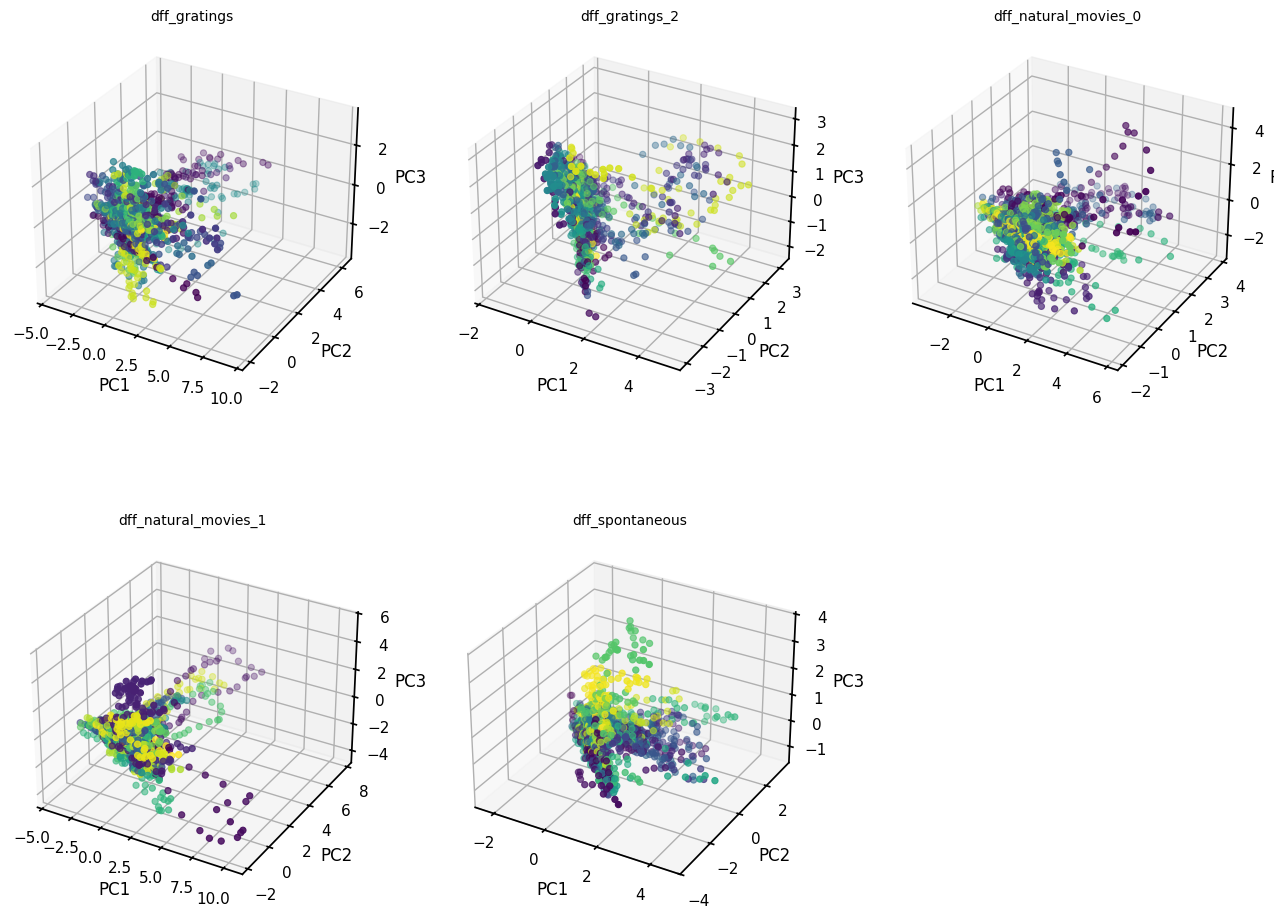

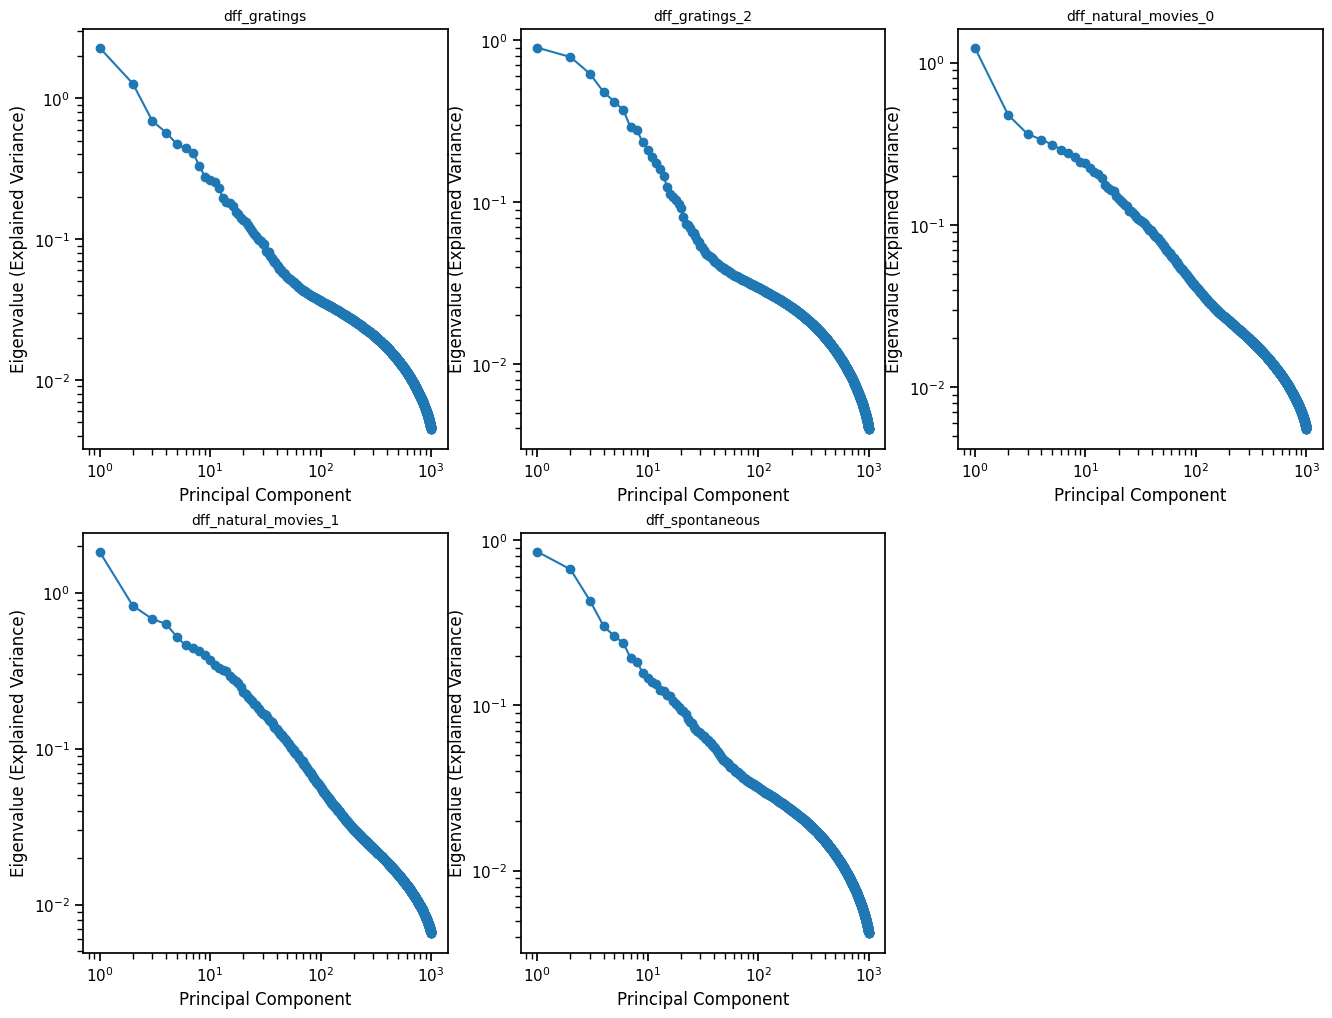

In [146]:
# To calculate the PCA manifold for the dff data for each epoch -AC
fig1,ax1 = plt.subplots(2,3, figsize=(16,12), subplot_kw ={'projection': '3d'})
fig2,ax2 = plt.subplots(2,3, figsize=(16,12))
ax1= ax1.flatten()
ax2= ax2.flatten()
for idx, key in enumerate(dff_key_list):
    dff_epoch = dff_dict[key].T # shape: (n_timepoints, n_cells)
    pca = PCA(n_components=1000)
    pca_result = pca.fit_transform(dff_epoch)  
    sc = ax1[idx].scatter3D(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],c=np.arange(0,dff_epoch.shape[0])/2, cmap='viridis', lw=0.8)
    fig1.colorbar(sc, ax = ax, shrink = 0.5, pad = 0.1)
    ax1[idx].set_xlabel('PC1')
    ax1[idx].set_ylabel('PC2')
    ax1[idx].set_zlabel('PC3')
    ax1[idx].set_title(f'{key}', fontsize = 10, ha='center')

    # Plot eigenvalue spectrum (explained variance)
    ax2[idx].plot(np.arange(1, len(pca.explained_variance_)+1), pca.explained_variance_, marker='o')
    ax2[idx].set_xlabel('Principal Component')
    ax2[idx].set_ylabel('Eigenvalue (Explained Variance)')
    ax2[idx].set_yscale('log')
    ax2[idx].set_xscale('log')
    ax2[idx].set_title(f'{key}', fontsize =10,  ha='center')
ax1[5].axis('off')
ax2[5].axis('off')
fig1.savefig('/results/PCA.png',format='png')
fig2.savefig('/results/eigen.png', format='png')

In [162]:
# To filter out choristers and soloists for specific epoch - AC 

dff_subset = dff_dict[dff_key_list[0]]
dff_subset_choristers = dff_subset[choirists_idx[0]]
print(dff_subset_chorister.shape)
dff_subset_soloists = dff_subset[soloists_idx[0]]
print(dff_subset_soloists.shape)

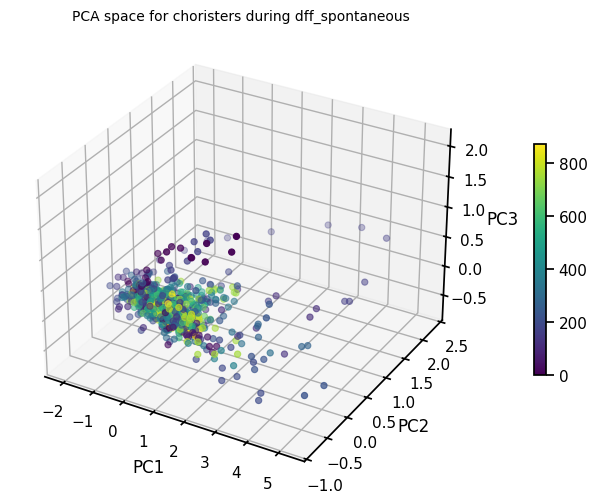

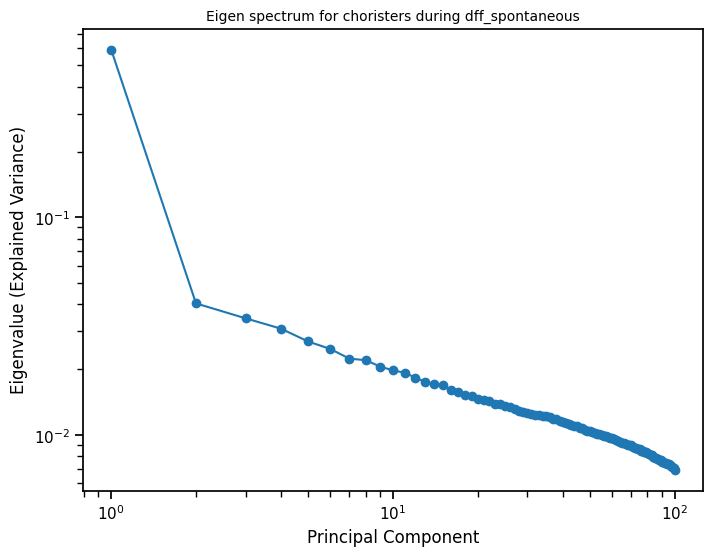

In [164]:
# To plot the PCA manifold and eigen spectrum for the choristers detected during gratings separately -AC

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_subplot(111)
pca = PCA(n_components=100)
pca_result = pca.fit_transform(dff_subset_choristers.T)  
sc = ax.scatter3D(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],c=np.arange(0,dff_subset_choristers.shape[1])/2, cmap='viridis', lw=0.8)
fig.colorbar(sc, ax = ax, shrink = 0.5, pad = 0.1)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title(f'PCA space for choristers during {key}', fontsize = 10, ha='center')
fig1.savefig('/results/chorister_PCA.png', format = 'png')
ax2.plot(np.arange(1, len(pca.explained_variance_)+1), pca.explained_variance_, marker='o')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Eigenvalue (Explained Variance)')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_title(f'Eigen spectrum for choristers during {key}', fontsize =10,  ha='center')
fig2.savefig('/results/chorister_ES.png', format = 'png')

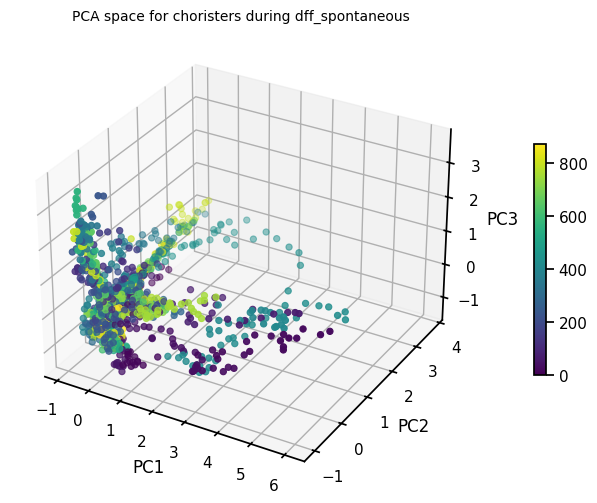

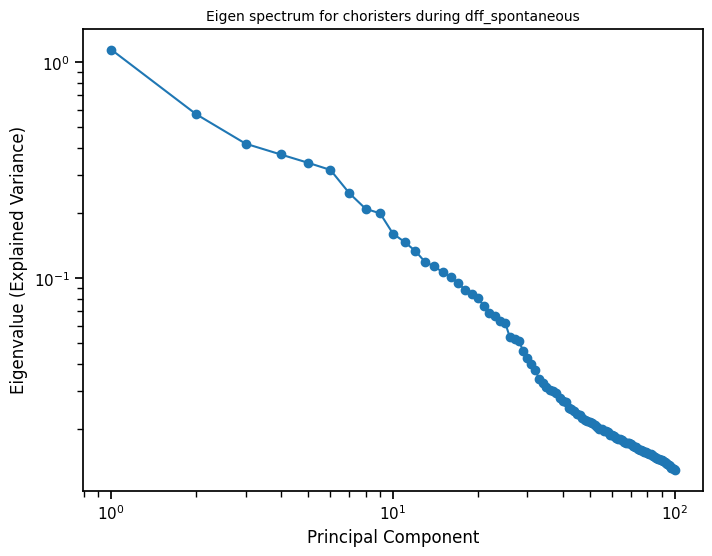

In [165]:
# To calculate the PCA manifold and eigen spectrum for the soloists detected during gratings separately -AC
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_subplot(111)
pca = PCA(n_components=100)
pca_result = pca.fit_transform(dff_subset_soloists.T)  
sc = ax.scatter3D(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],c=np.arange(0,dff_subset_soloists.shape[1])/2, cmap='viridis', lw=0.8)
fig.colorbar(sc, ax = ax, shrink = 0.5, pad = 0.1)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title(f'PCA space for choristers during {key}', fontsize = 10, ha='center')
fig1.savefig('/results/soloists_PCA.png', format = 'png')
ax2.plot(np.arange(1, len(pca.explained_variance_)+1), pca.explained_variance_, marker='o')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Eigenvalue (Explained Variance)')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_title(f'Eigen spectrum for choristers during {key}', fontsize =10,  ha='center')
fig2.savefig('/results/soloists_ES.png', format = 'png')

In [114]:
# # tt_result = scipy.stats.ttest_ind(list_of_dff_by_condition[3], baseline_dff, equal_var=False)
# is_significant = []
# p_values = []
# n_trials = []
# for dff in list_of_dff_by_condition:
#     _, pvalue = scipy.stats.mannwhitneyu(
#         dff, baseline_dff,
#         alternative='greater',  # is neuron response significantly greater than baseline?
#         method='exact',  # recommended when there are no ties and when either sample size < 8
#     )

#     p_values.append(pvalue)
#     n_trials.append(dff.size)
#     # Bonferonni correction. Much more conservative, but seems more consistent
#     is_significant.append(pvalue < (0.05 / dff.size))

#     # BH-FDR correction. More relaxed, picking up on activities that idk
#     # qvalue = scipy.stats.false_discovery_control(pvalue)
#     # is_significant.append(qvalue < 0.01)

# p_values = np.array(p_values).T
# n_trials = np.array(n_trials).T
# is_significant = np.array(is_significant).T
# p_values.shape, n_trials.shape, is_significant.shape

In [115]:
# # To create a dataframe for choirists and soloists 
# results=[]
# selected_session_data.keys()
# cell_class_table =pd.DataFrame({
#     'plane_ids': selected_session_data['plane_ids'],
#     'roi_ids': selected_session_data['roi_ids']
# })


# cell_class_table['cell_class'] = np.nan  # default to 0
# for idx, (key,p_coupling) in enumerate(cell_coupling.items()):

#     temp_df = cell_class_table.copy()
    
#     temp_df.loc[soloists_idx[idx], 'cell_class'] = 1
#     temp_df.loc[choirists_idx[idx], 'cell_class'] = 0
#     temp_df['p_coupling_value'] = p_coupling
#     temp_df['stimulus'] = key
#     results.append(temp_df)
# final_df = pd.concat(results, ignore_index=True)

# final_df['cell_class'].value_counts(dropna = False)
# # TO save the dataframe to metadata folder
# final_df.to_csv('/data/volume3_cell_class.csv', index=False)
# print(final_df[final_df['stimulus'] == '*spontaneous']['cell_class'].value_counts(dropna = False).sum())
# final_df['stimulus'].unique()

In [116]:
# To create a dataframe for choirists and soloists 
results=[]

cell_class_table = pd.DataFrame(columns=['column_id','volume_id', 'plane_ids', 'roi_ids', 'cell_class', ])

for epoch_set in list_of_epoch_data: 
    row_dict = {
        'column_id': epoch_set['column_ids'],
        'volume_id': epoch_set['volume_ids'],
        'plane_ids': epoch_set['plane_ids'],
        'roi_ids': epoch_set['roi_ids'],
       
    }
    cell_class_table = pd.concat([cell_class_table, pd.DataFrame([row_dict])], ignore_index=True)                                    

In [117]:
# cell_class_table['cell_class'] = np.nan  # default to 0
# for idx, (key,p_coupling) in enumerate(cell_coupling.items()):

#     temp_df = cell_class_table.copy()
#     temp_df.loc[soloists_idx[idx], 'cell_class'] = 1
#     temp_df.loc[choirists_idx[idx], 'cell_class'] = 0
#     temp_df['p_coupling_value'] = p_coupling
#     temp_df['stimulus'] = key
#     results.append(temp_df)

# final_df = pd.concat(results, ignore_index=True)

# final_df['cell_class'].value_counts(dropna = False)
# # TO save the dataframe to metadata folder
# final_df.to_csv('/data/volume3_cell_class.csv', index=False)
# print(final_df[final_df['stimulus'] == '*spontaneous']['cell_class'].value_counts(dropna = False).sum())
# final_df['stimulus'].unique()

(2708, 1742)
(2708, 1735)
(2708, 2725)
(2708, 3267)
(2708, 1820)


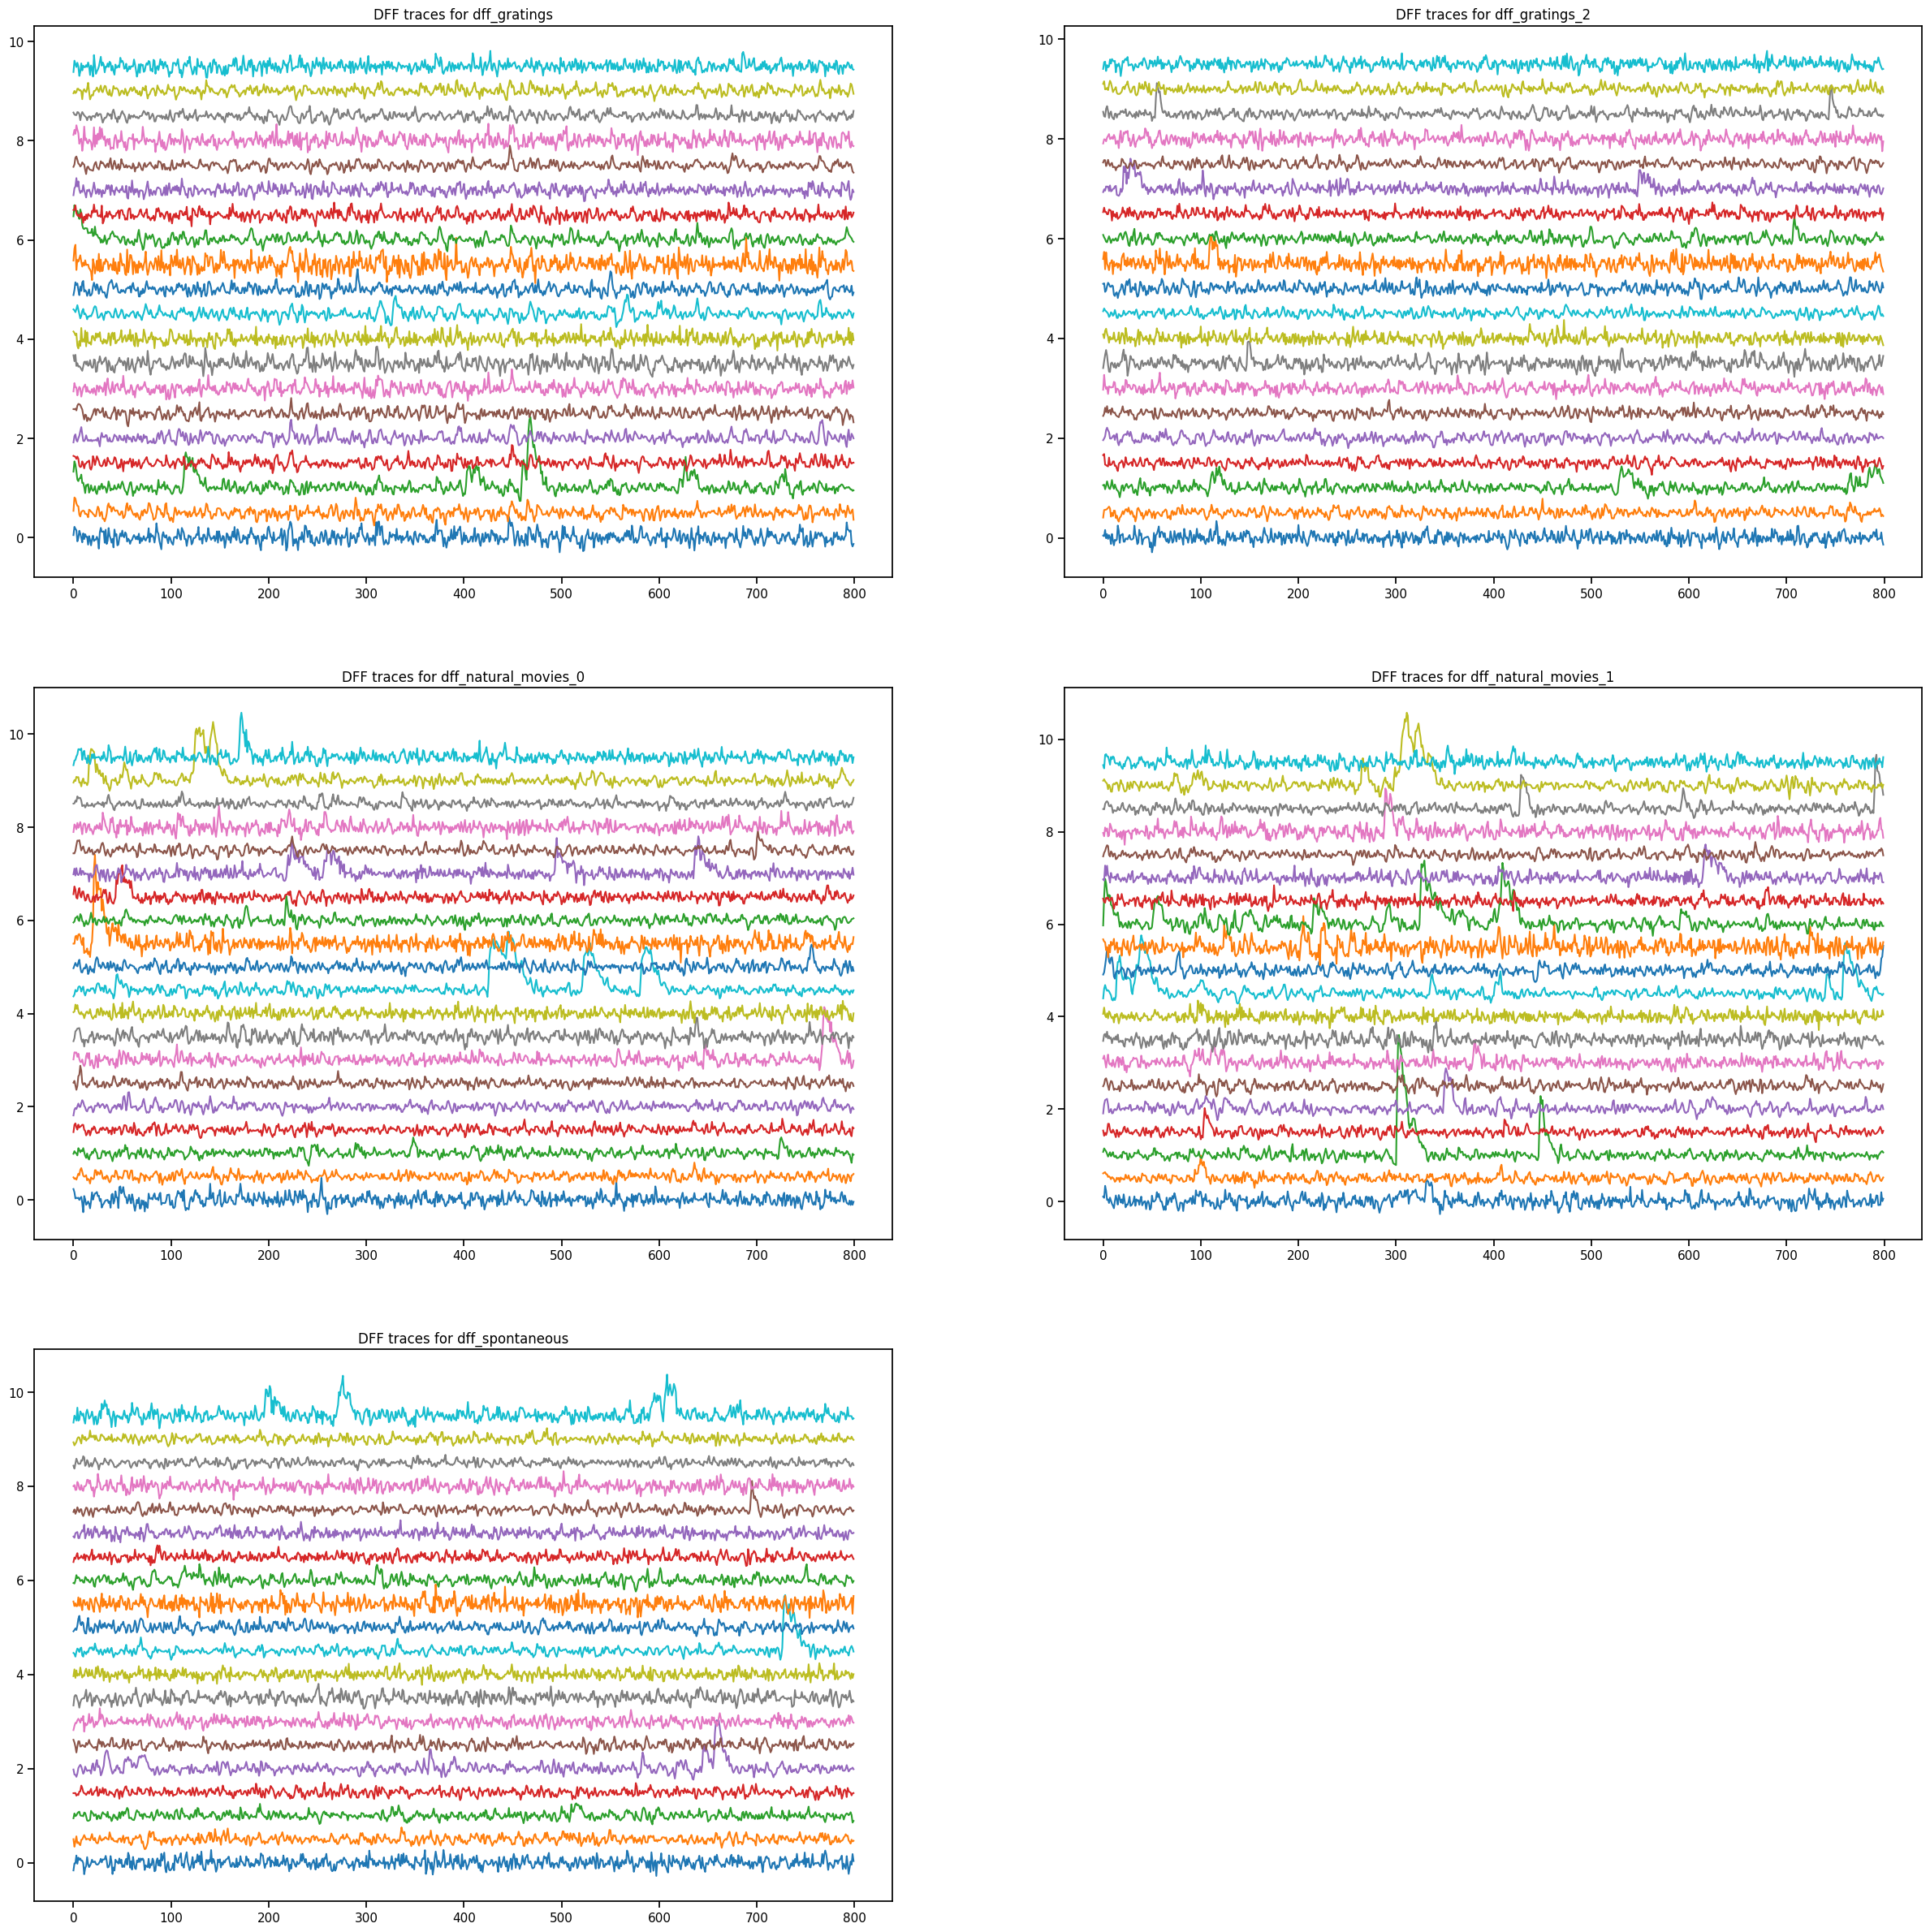

In [166]:
# Code to plot random traces from different DFF traces - AC

fig, axs = plt.subplots(nrows = 3, ncols =2 , figsize=(30,30))
axs = axs.flatten()  # make it easy to index
dff_dict = {'dff_gratings' : dff_drifting_gratings_0, 'dff_gratings_2' : dff_drifting_gratings_1, 'dff_natural_movies_0' : dff_natural_movies_0, 'dff_natural_movies_1' : dff_natural_movies_1, 'dff_spontaneous' : dff_spontaneous}
np.random.seed(42) 
twenty_random_traces = np.random.randint(1,dff_dict['dff_gratings'].shape[0],20)
offset = np.arange(0,20)
offset = 0.5 * offset.reshape(-1,1)
for idx,(name,i) in enumerate (dff_dict.items()):
    print(i.shape)
    axs[idx].plot((i[twenty_random_traces ,0:800]+offset).T)
    axs[idx].set_title(f"DFF traces for {name}")
axs[5].axis('off') 
plt.savefig('/results/DFF_traces_all_epochs.png',format='png')

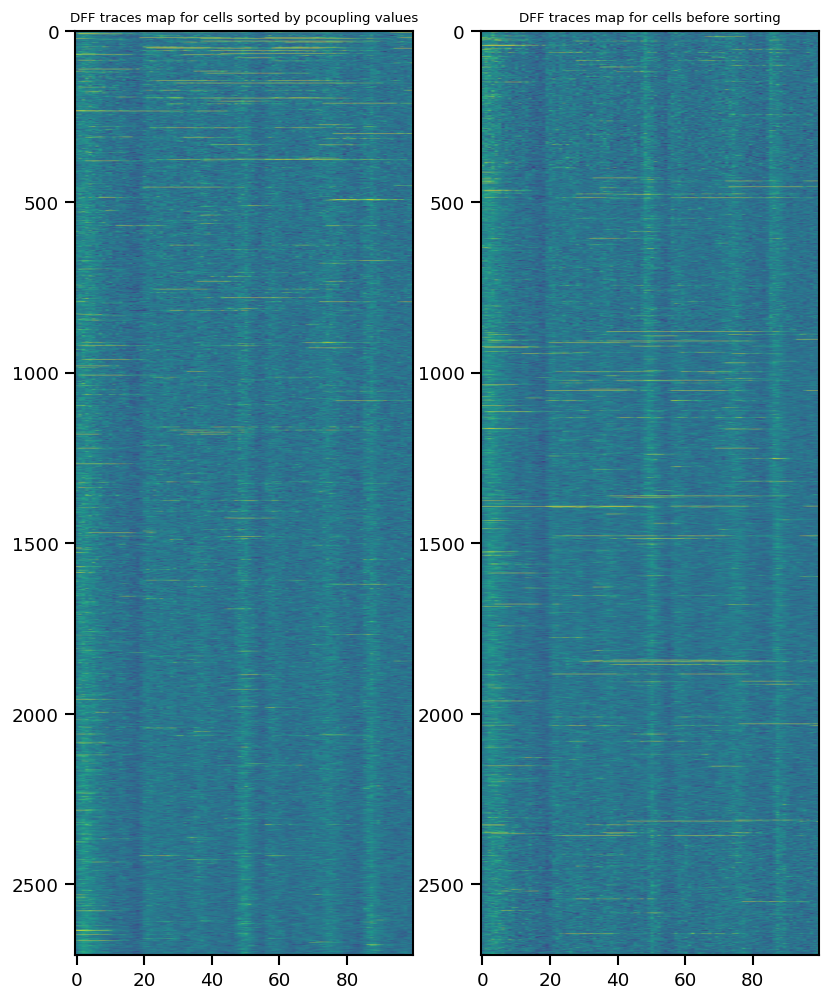

In [171]:
# To sort cells based on their population coupling - AC
sorting_off = np.argsort(cell_coupling['p_coupling_drifting_gratings_full'].flatten())
dff_sort = dff_dict['dff_gratings'][sorting_off]
fig, axs = plt.subplots(1,2, figsize=(8,10), dpi =120)
axs[0].imshow(dff_sort[:, 0:100], aspect='auto', vmax=0.7)
axs[0].set_title('DFF traces map for cells sorted by pcoupling values', fontsize=8)
axs[1].imshow(dff_dict['dff_gratings'][:, 0:100], aspect='auto', vmax=0.7)
axs[1].set_title('DFF traces map for cells before sorting', fontsize=8)
fig.savefig('/results/sorted_vs_unsorted.png',format='png')

In [148]:
# TO create a cell_class dataframe to look for structural correlates - AC

rows = []
stimulus = ["p_coupling_drifting_gratings_full", "p_coupling_spontaneous", "p_coupling_natural_movies", "p_coupling_drifting_gratings_full_1", "p_coupling_natural_movies_1"]
results = []
for idx, epoch in enumerate(list_of_epoch_data):
    plane_ids = epoch['plane_ids']
    roi_ids = epoch['roi_ids']
    dff_means = epoch['dff_traces'].T.mean(axis=1)  # Adjust as needed
    stimulus_tray = [stimulus[idx]]* len(epoch['plane_ids'])
    # Optionally, get cell_class and P_values if available
    cell_classes = epoch.get('cell_class', [None]*len(plane_ids))
    p_values = epoch.get('P_values', [None]*len(plane_ids))
    
    for i in range(len(plane_ids)):
        row = {
            "plane": plane_ids[i],
            "roi": roi_ids[i],
            "dff_mean": dff_means[i] if hasattr(dff_means, '__getitem__') else dff_means,
            "cell_class": cell_classes[i] if hasattr(cell_classes, '__getitem__') else cell_classes,
            "p_values": p_values[i] if hasattr(p_values, '__getitem__') else p_values,
            "stimulus" : stimulus_tray[i] 
        }
        rows.append(row)

cell_class_df = pd.DataFrame(rows, columns=["plane", "roi", "dff_mean", "cell_class","p_values", "stimulus"])
cell_class_df.head()
for idx, (key,p_coupling) in enumerate(cell_coupling.items()):

    temp_df = cell_class_df[cell_class_df['stimulus'] == key].reset_index(drop = True)
    temp_df.loc[soloists_idx[idx], 'cell_class'] = 1
    temp_df.loc[choirists_idx[idx], 'cell_class'] = 0
    temp_df['p_values'] = p_coupling
    temp_df['stimulus'] = key
    results.append(temp_df)
results = pd.concat(results)

In [154]:
results.to_csv('vol3_pcoupling.csv', index=False)

In [191]:

print(dff_dict['dff_gratings'].shape)
dff_choirists = dff_dict['dff_gratings'][choirists_idx[0]]
dff_soloists = dff_dict['dff_gratings'][soloists_idx[0]]
offset_choirists = 0.5 * np.arange(dff_choirists.shape[0]).reshape(-1, 1)

print(dff_choirists.shape)
plt.figure(figsize=(20, 100))
for idx,i in enumerate(dff_choirists):
    plt.plot((i+offset_choirists[idx]).T)
    plt.title(f"DFF traces for {name}")
plt.close()

(2708, 1742)
(440, 1742)


In [192]:
print(dff_dict['dff_gratings'].shape)
dff_choirists = dff_dict['dff_gratings'][choirists_idx[0]]
dff_soloists = dff_dict['dff_gratings'][soloists_idx[0]]
offset_choirists = 0.5 * np.arange(dff_soloists.shape[0]).reshape(-1, 1)

print(dff_soloists.shape)
plt.figure(figsize=(20, 100))
for idx,i in enumerate(dff_soloists):
    plt.plot((i+offset_choirists[idx]).T)
    plt.title(f"DFF traces for {name}")
plt.close()

(2708, 1742)
(411, 1742)
